In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from src.hdmm import workload, fairtemplates, error, fairmechanism, matrix, mechanism, templates

In [2]:
def pmw(workload, x, eps=0.01, beta=0.1, k=0, show_messages=True, to_return='pd', analyst_labels = []):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries. New arguments to allow for optimizing the amount of
    privacy budget used in each step.
    
    to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query (query, d_t_hat, updated, algo_ans, real_ans, abs_error, 
        rel_error). 
        - if 'update_count', pmw() returns the update count for the total
        amount of queries

    - W = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    """ 
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    if k==0: # essentially, if k hasn't been changed from its default value, use the length of the workload
        k = len(workload)  # num of queries
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    eta = (math.log(m, np.e) ** (1 / 4)) / (math.sqrt(n))
    sigma = 10 * math.log(1 / delta, np.e) * ((math.log(m, np.e)) ** (1 / 4)) / (
            math.sqrt(n) * eps)
    threshold = 4 * sigma * (math.log(k, np.e) + math.log(1 / beta, np.e))
    
    # synthetic databases at time 0 (prior to any queries)
    y_t = np.ones(m) / m
    x_t = np.ones(m) / m

    # append to list of databases y_t and x_t
    x_list = [x_t]
    
    update_list = []
    update_count = 0
    pmw_answers = []
    update_times = []
    d_t_hat_list = []
    
    failure_mode = False # if reaches failure, failure mode because true and only runs lazy rounds
    
    def lazy_round():
        update_list.append('no')
        pmw_answers.append(np.dot(query, x_list[time]))
        x_list.append(x_list[time])
        
    
    # iterate through time = (0, k)
    for time, query in enumerate(workload):
        # compute noisy answer by adding Laplacian noise
        a_t = np.random.laplace(loc=0, scale=sigma, size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + a_t

        # difference between noisy and maintained histogram answer
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        d_t_hat_list.append(d_t_hat)

        # lazy round: use maintained histogram to answer the query
        if abs(d_t_hat) <= threshold or failure_mode:
            lazy_round()
            continue

        # update round: update histogram and return noisy answer
        else:
            update_times.append(time)

            # step a
            if d_t_hat < 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i, v in enumerate(y_t):
                y_t[i] = x_list[time][i] * math.exp(-eta * r_t[i])
            
            #print(d_t_hat)
            #print(r_t)
            #print(x_list[time])
            # step b
            x_t = y_t / np.sum(y_t)
            update_count = update_list.count('yes')
            
            if update_count > n * math.log(m, np.e) ** (1 / 2): # threshold for num updates is reached, enter failure_mode
                failure_mode = True
                print(f'Failure mode reached at query number {time}: {query}')
                lazy_round()
            else: # threshold for num updates is not reached yet
                x_list.append(x_t)
                update_list.append('yes') # increment number of updates counter
                pmw_answers.append(a_t_hat / np.sum(x))
                
    update_count = update_list.count('yes')      

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(pmw_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))
    
    
    def print_outputs():
        np.set_printoptions(suppress=True)
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Updated Database = {x_t}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{threshold=}\n')
        print(f'Error Scale = {sigma}\n')
        print(f'Update Parameter Scale = {eta}\n')
        print(f'{delta=}\n')
    
    def plot_error():
        """Plot absolute and relative error"""
        plt.xticks(range(0, k, 5))
        plt.title('Error across queries:')
        rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[rel_line, abs_line])
    
    if show_messages:
        print_outputs()
        plot_error()
        
    if to_return == "update_count":
        return update_count

    if to_return == "pd":
        x_list.pop(0).tolist() # remove the first synthetic database to keep length of lists consistent-x_list[t] represents the synthetic database at the end of time t
        d = {
            'queries': workload.tolist(), 
            'd_t_hat': d_t_hat_list, 
            'updated': update_list,
            'algo_ans': pmw_answers,
            'real_ans': real_ans.tolist(),
            'abs_error': abs_error,               
            'rel_error': rel_error,
            'synthetic database': x_list,
            'analyst': analyst_labels,
             }
        test_data = pd.DataFrame(data=d)
        return test_data

## Failure Scenario:

Alice and Bob are analysts who query from a database, x_small, that uses private multiplicative weights in an online setting. Alice submits a set of 500 queries that only queries the first half of the database (indexes 0, 1, 2, 3). Alice's queries come first and use all the budget. Practically, that means Alice runs queries until output = failure. Then Bob does queries on index 5-7 on the synthetic database. 

Parameters: 
- x_small: [10, 80, 13, 12, 90, 14, 17, 17]
- Number of Alice's queries: 450, they only query from the **first four** slots in x_small
- Number of Bob's queries: 450, they only query from the **last four** slots in x_small


In [3]:
#x_small = np.array([10, 80, 13, 12, 90, 14, 17, 17])
x_small = np.array([1, 8, 1, 1, 9, 1, 1, 1])
normalized = x_small / x_small.sum()
print(normalized)
m = x_small.size  # database len
n = x_small.sum()
print(f'the threshold for failure is {n * math.log(m, np.e) ** (1 / 2)}')

[0.04347826 0.34782609 0.04347826 0.04347826 0.39130435 0.04347826
 0.04347826 0.04347826]
the threshold for failure is 33.16661839182031


In [4]:
random_array = np.random.randint(2, size=(500,4))
zero_array = np.zeros((500,4))
alice = np.hstack((random_array, zero_array))
bob = np.hstack((zero_array, random_array))

Original database: [1 8 1 1 9 1 1 1]

Normalized database: [0.04347826 0.34782609 0.04347826 0.04347826 0.39130435 0.04347826
 0.04347826 0.04347826]

Updated Database = [0.04572128 0.33890185 0.05873038 0.05873038 0.12447902 0.12447902
 0.12447902 0.12447902]

Update Count = 10

threshold=1.3410452971363842

Error Scale = 0.04285012176805998

Update Parameter Scale = 0.25039333289159305

delta=0.013866477778426131



,queries,d_t_hat,updated,algo_ans,real_ans,abs_error,rel_error,synthetic database,analyst
0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",-1.876742,yes,0.043403,0.043478,0.000076,0.001742,"[0.12855958155236688, 0.12855958155236688, 0.1...",Alice
1,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-3.890442,yes,0.087970,0.086957,0.001013,0.011649,"[0.10612722535041122, 0.13632366478975327, 0.1...",Alice
2,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3.375294,yes,0.389203,0.391304,0.002102,0.005371,"[0.09927852705063427, 0.16381143344825186, 0.0...",Alice
3,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",-3.341254,yes,0.081533,0.086957,0.005424,0.062371,"[0.08137599798935069, 0.17247639097753553, 0.1...",Alice
4,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-2.265683,yes,0.087398,0.086957,0.000441,0.005077,"[0.06607154054428788, 0.1798838624759055, 0.08...",Alice
...,...,...,...,...,...,...,...,...,...
495,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",-0.610922,no,0.502084,0.478261,0.023823,0.049812,"[0.04572128230818544, 0.3389018538011934, 0.05...",Alice
496,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.476573,no,0.104452,0.086957,0.017495,0.201194,"[0.04572128230818544, 0.3389018538011934, 0.05...",Alice
497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.053525,no,0.000000,0.000000,0.000000,0.000000,"[0.04572128230818544, 0.3389018538011934, 0.05...",Alice
498,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",-0.188856,no,0.443354,0.434783,0.008571,0.019713,"[0.04572128230818544, 0.3389018538011934, 0.05...",Alice


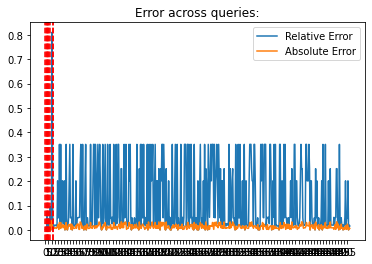

In [5]:
# just alice
alice_labels = ['Alice'] * 500
pmw(workload=alice, x=x_small, eps=250, beta=0.2, k=500, to_return='pd', analyst_labels = alice_labels)

Original database: [1 8 1 1 9 1 1 1]

Normalized database: [0.04347826 0.34782609 0.04347826 0.04347826 0.39130435 0.04347826
 0.04347826 0.04347826]

Updated Database = [0.11353142 0.11353142 0.11353142 0.11353142 0.39704369 0.04170022
 0.0535652  0.0535652 ]

Update Count = 13

threshold=1.3410452971363842

Error Scale = 0.04285012176805998

Update Parameter Scale = 0.25039333289159305

delta=0.013866477778426131



,queries,d_t_hat,updated,algo_ans,real_ans,abs_error,rel_error,synthetic database,analyst
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",-1.851972,yes,0.044479,0.043478,0.001001,0.023028,"[0.12855958155236688, 0.12855958155236688, 0.1...",Bob
1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]",4.101020,yes,0.435424,0.434783,0.000642,0.001476,"[0.11979554762815675, 0.11979554762815675, 0.1...",Bob
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]",-2.716168,yes,0.094961,0.086957,0.008005,0.092057,"[0.1257290816225832, 0.1257290816225832, 0.125...",Bob
3,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]",4.428357,yes,0.430239,0.434783,0.004544,0.010451,"[0.11776429151680357, 0.11776429151680357, 0.1...",Bob
4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]",2.066744,yes,0.435444,0.434783,0.000661,0.001520,"[0.1072212739667913, 0.1072212739667913, 0.107...",Bob
...,...,...,...,...,...,...,...,...,...
495,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]",-0.599573,no,0.545874,0.521739,0.024135,0.046259,"[0.11353142287439989, 0.11353142287439989, 0.1...",Bob
496,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]",-0.250815,no,0.450609,0.434783,0.015826,0.036400,"[0.11353142287439989, 0.11353142287439989, 0.1...",Bob
497,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.009955,no,0.000000,0.000000,0.000000,0.000000,"[0.11353142287439989, 0.11353142287439989, 0.1...",Bob
498,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0]",-0.326423,no,0.492309,0.478261,0.014048,0.029374,"[0.11353142287439989, 0.11353142287439989, 0.1...",Bob


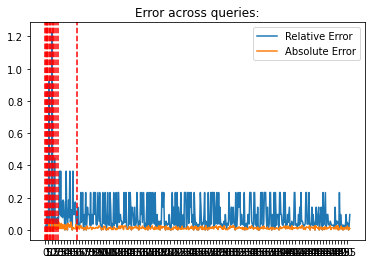

In [6]:
# just bob
bob_labels = ['Bob'] * 500
pmw(workload=bob, x=x_small, eps=250, beta=0.2, k=500, to_return='pd', analyst_labels = bob_labels)

Failure mode reached at query number 923: [0. 0. 0. 0. 1. 1. 0. 0.]
Original database: [1 8 1 1 9 1 1 1]

Normalized database: [0.04347826 0.34782609 0.04347826 0.04347826 0.39130435 0.04347826
 0.04347826 0.04347826]

Updated Database = [0.03427646 0.32635927 0.04402916 0.04402916 0.41921846 0.04402916
 0.04402916 0.04402916]

Update Count = 34

threshold=0.7299255307485543

Error Scale = 0.02142506088402999

Update Parameter Scale = 0.25039333289159305

delta=0.013866477778426131



,queries,d_t_hat,updated,algo_ans,real_ans,abs_error,rel_error,synthetic database,analyst
0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",-1.926983,yes,0.041218,0.043478,0.002260,0.051983,"[0.12855958155236688, 0.12855958155236688, 0.1...",Alice
1,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-3.911354,yes,0.087060,0.086957,0.000104,0.001194,"[0.10612722535041122, 0.13632366478975327, 0.1...",Alice
2,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3.435908,yes,0.391838,0.391304,0.000534,0.001364,"[0.09927852705063427, 0.16381143344825186, 0.0...",Alice
3,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",-3.219318,yes,0.086834,0.086957,0.000122,0.001404,"[0.08137599798935069, 0.17247639097753553, 0.1...",Alice
4,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-2.190264,yes,0.090677,0.086957,0.003721,0.042786,"[0.06607154054428788, 0.1798838624759055, 0.08...",Alice
...,...,...,...,...,...,...,...,...,...
995,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]",0.491160,no,0.500000,0.521739,0.021739,0.041667,"[0.03819580427868227, 0.36367683958495134, 0.0...",Bob
996,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]",0.502931,no,0.412741,0.434783,0.022042,0.050697,"[0.03819580427868227, 0.36367683958495134, 0.0...",Bob
997,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.002645,no,0.000000,0.000000,0.000000,0.000000,"[0.03819580427868227, 0.36367683958495134, 0.0...",Bob
998,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0]",0.622653,no,0.450936,0.478261,0.027325,0.057133,"[0.03819580427868227, 0.36367683958495134, 0.0...",Bob


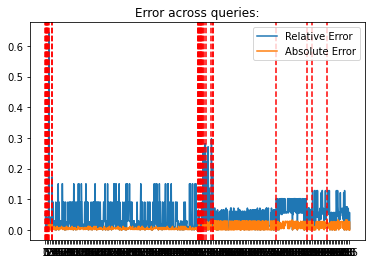

In [7]:
# alice and bob combined
bob_labels = ['Bob'] * 500
pmw(workload=np.vstack((alice, bob)), x=x_small, eps=500, beta=0.2, k=1000, to_return='pd', analyst_labels = alice_labels + bob_labels)

Failure Task: 
- [DO] Calculate error difference. 
- [DO] Create normal distribution workloads
- Use a smaller database so the threshold is less
- Output when failure happened, 
- no longer update from that point and just use synthetic database (only do lazy rounds)
- in order to make it only do lazy rounds, create variable that goes into failure_mode
- fix synthetic database so that it actually updates
- Create a parallel list of people - output the labelled person, i.e. "alice" into a list. output this as a column as well
- PMW with just Alice and just bob - Split k and epsilon in half

Sept 14th notes: 
- I Realized that it's a lot harder to reach failure mode in the new update setting with the current functions. Question: What other types of queries/databases should I try to make updating more frequent? 
- 